## import libraries

In [1]:
import warnings
warnings.filterwarnings('ignore')

In [2]:
import string
import numpy as np
import pandas as pd
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import accuracy_score
from sklearn.svm import SVC
from sklearn.naive_bayes import MultinomialNB
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import confusion_matrix,classification_report, accuracy_score,precision_score, recall_score, f1_score
from gensim.models import KeyedVectors  # Requires gensim library

import nltk
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
from nltk.stem import WordNetLemmatizer
from nltk.stem.porter import PorterStemmer

In [3]:
nltk.download('stopwords')
nltk.download('punkt')

[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\abdul\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\abdul\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!


True

## read data

In [4]:
# Replace 'file_path.xlsx' with the path to your Excel file
file_path = 'dataset/data.xlsx'

# Read the Excel file into a DataFrame
df = pd.read_excel(file_path)

# Display the contents of the DataFrame
print(df)


       code                                               text
0       606  A country built with common welfare and solida...
1       305  The bourgeois government has broken down much ...
2       305  The result is an increasingly insecure labor m...
3       305  The Left Party stands for an alternative that ...
4       305  Sweden faces a number of challenges that must ...
...     ...                                                ...
80354   301  care must be taken to ensure that the municipa...
80355   414     and only incur debt when absolutely necessary.
80356   301  Where there is no merger of municipalities, co...
80357   303  Out of frugality, the communities should also ...
80358   301  The ADR also encourages cooperation between ne...

[80359 rows x 2 columns]


# Preprocessing
## Utils fuunctions

In [5]:
def count_digit(num):
    count = 0
    while num != 0:
        num //= 10
        count += 1
    return count

def check_shape(df):
    rows, cols = df.shape
    print("\nNumber or rows in dataset: {}".format(rows))
    print("==========================={}".format(count_digit(rows)*'='))
    print("\nNumber or columns in dataset: {}".format(cols))
    print("=============================={}".format(count_digit(cols)*'='))

## rename columns

In [6]:
# renamme colummn
df.rename(columns = {'code':'labels'}, inplace = True)
df = df[['text', 'labels']]
# check the numbber of rows and   coolumnss in datasset
check_shape(df)
df.head()


Number or rows in dataset: 80359

Number or columns in dataset: 2


,text,labels
0,A country built with common welfare and solida...,606
1,The bourgeois government has broken down much ...,305
2,The result is an increasingly insecure labor m...,305
3,The Left Party stands for an alternative that ...,305
4,Sweden faces a number of challenges that must ...,305


## remove nan and empty rows

In [7]:
df = df[df['labels'] != '0.0']
check_shape(df)
df = df[df.labels.notnull()]
check_shape(df)


Number or rows in dataset: 80359

Number or columns in dataset: 2

Number or rows in dataset: 80359

Number or columns in dataset: 2


## Extract number of classes aand their count

In [8]:
classes = list(df.labels.unique())
possible_labels = df.labels.unique()
print("\nNummber of classes in dataset: {}".format(len(classes)))
print("==============================={}".format(count_digit(len(classes))*'='))
print("\nName of the classes")
print("===================\n")
print(classes,"\n")


Nummber of classes in dataset: 62

Name of the classes

[606, 305, 415, 706, 404, 604, 703, 408, 414, 109, 105, 103, 602, 601, 413, 405, 401, 406, 410, 106, 104, 608, 704, 409, 702, 302, 505, 407, 607, 705, 603, 507, 204, 304, 110, 203, 402, 701, 201, 503, 411, 502, 107, 506, 605, 403, 303, 504, 501, 416, 301, 108, 412, 202, 101, 102, 6014, 7061, 7062, 1016, 4132, 7051] 



In [9]:
classes_counts = df.labels.value_counts()
print("\nclasses counts")
print("==============\n")
print(classes_counts)


classes counts

501     3961
411     3542
506     3120
503     3112
504     2894
        ... 
7061       1
7062       1
1016       1
4132       1
7051       1
Name: labels, Length: 62, dtype: int64


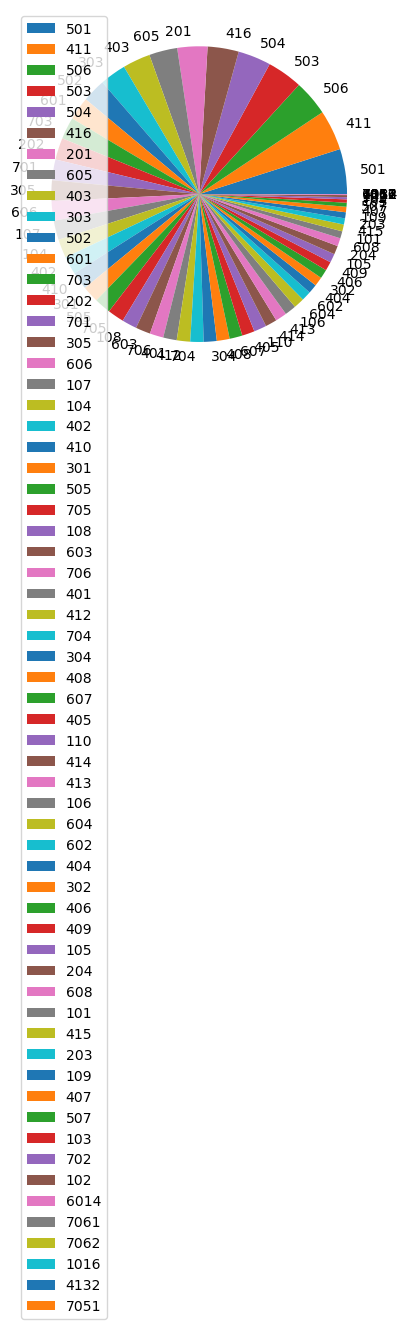

In [10]:
# display classes count
import matplotlib.pyplot as plt
import numpy as np

values = np.array(classes_counts)
mylabels = list(classes_counts.index)

plt.pie(values, labels = mylabels)
plt.legend()
plt.show() 

## Class Balancing 

In [11]:
classes = list(df.labels.value_counts().index)
counts = list(df.labels.value_counts())

counts_df = pd.DataFrame({'class': classes, 'count': counts})
counts_df

,class,count
0,501,3961
1,411,3542
2,506,3120
3,503,3112
4,504,2894
...,...,...
57,7061,1
58,7062,1
59,1016,1
60,4132,1


In [12]:
counts_df = counts_df[counts_df['count'] > 1]
updated_classes = list(counts_df['class'])
len(updated_classes)

57

## data cleaning

In [13]:
# Preprocess text data by removing stop words
def preprocess_text(text):
    if isinstance(text, str):
        words = word_tokenize(text)
        filtered_words = [word for word in words if word not in stop]
        return " ".join(filtered_words)
    elif isinstance(text, float):
        return ""  # Return an empty string for float values
    else:
        return str(text)  # Convert other types to string

In [14]:
# Get the set of English stop words
stop = set(stopwords.words('english'))

df['text'] = df['text'].apply(preprocess_text)
df['text'] = df['text'].apply(
    lambda x: " ".join(x.lower() for x in x.split()))  # lower case conversion
df['text'] = df['text'].str.replace('[^\w\s]', '')  # getting rid of special characters
df['text'] = df['text'].str.replace('\d+',
                                                        '')  # removing numeric values from between the words
df['text'] = df['text'].apply(
    lambda x: x.translate(string.digits))  # removing numerical numbers
stop = stopwords.words('english')
df['text'] = df['text'].apply(
    lambda x: " ".join(x for x in x.split() if x not in stop))  # removing stop words

## Labels Encoder

In [15]:
df = df[df['labels'].isin(updated_classes)]

le = LabelEncoder()
df['labels'] = le.fit_transform(df['labels'])

classes = list(df.labels.unique())
# Convert integers to strings using the map() function
classes_str = list(map(str, classes))



# Split the data into training and testing sets
X = df['text'].tolist()
y = df['labels']

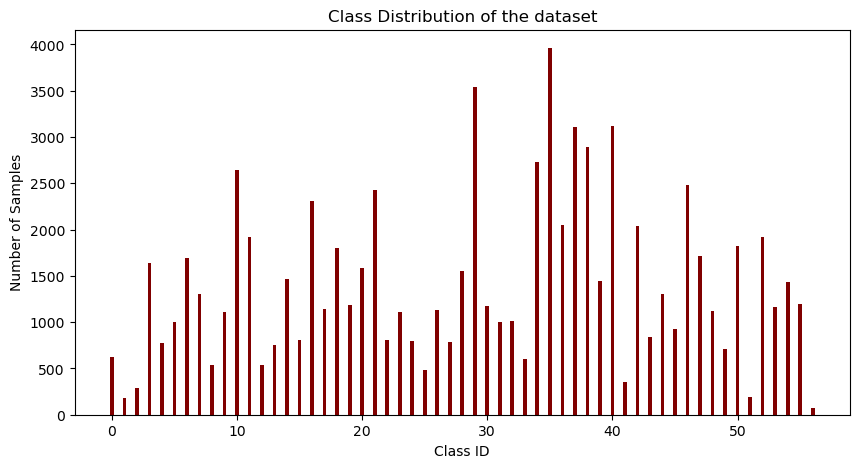

In [16]:
mylabels = list(df.labels.value_counts().index)
values = list(df.labels.value_counts())

fig = plt.figure(figsize = (10, 5))
 
# creating the bar plot
plt.bar(mylabels, values, color ='maroon', width=0.3)
 
plt.xlabel("Class ID")
plt.ylabel("Number of Samples")
plt.title("Class Distribution of the dataset")
plt.show()

## Glove Embeddings

In [17]:
from gensim.scripts.glove2word2vec import glove2word2vec

# Convert GloVe format to Word2Vec format
glove_path = 'dataset/glove.6B.100d.txt'  # Update with your GloVe file path
word2vec_output_file = 'glove.6B.100d.word2vec.txt'
glove2word2vec(glove_input_file=glove_path, word2vec_output_file=word2vec_output_file)

# Load Word2Vec format embeddings
word_vectors = KeyedVectors.load_word2vec_format(word2vec_output_file, binary=False)

In [18]:
# Create feature vectors using GloVe embeddings
def average_word_vectors(words, model, num_features):
    feature_vector = np.zeros((num_features,), dtype="float64")
    n_words = 0
    for word in words:
        if word in model:
            n_words += 1
            feature_vector = np.add(feature_vector, model[word])
    if n_words > 0:
        feature_vector = np.divide(feature_vector, n_words)
    return feature_vector

num_features = 100  # Update with the embedding dimension of your GloVe model
X_vectors = [average_word_vectors(words.split(), word_vectors, num_features) for words in X]

## Train Test Split

In [19]:
X_train, X_test, y_train, y_test = train_test_split(X_vectors, y, test_size=0.2, random_state=42)

# ML Models

In [20]:
#dic form store results of all models
collect_results_of_all_model= {
    'Metrics':['accuracy','precision','recall','f1-score']
}

In [21]:
def calculate_tp_fp_rates(confusion_matrix):
    num_classes = confusion_matrix.shape[0]
    tp_scores = np.diagonal(confusion_matrix)
    fp_scores = np.sum(confusion_matrix, axis=0) - tp_scores
    
    tp_rates = tp_scores / np.sum(confusion_matrix, axis=1)
    fp_rates = fp_scores / np.sum(confusion_matrix, axis=1)
    
    tp_rates_percent = tp_rates * 100
    fp_rates_percent = fp_rates * 100
    
    return tp_rates_percent, fp_rates_percent


def plot_TP(tp_rates_percent, classes):
    # Set the desired figure size (width, height) in inches
    fig, ax = plt.subplots(figsize=(10, 6))  # Adjust the size as needed

    ax.bar(classes, tp_rates_percent, width=0.4)
    plt.xlabel('Classes')
    plt.ylabel('True Positive Rate (%)')
    plt.title('True Positive Rate for Each Class')
    plt.ylim(0, 100)  # Set y-axis limit to ensure visibility of bars
    plt.xticks(rotation=90, fontsize=8)
    plt.show()
    
    
def plot_FP(fp_rates_percent, classes):
    # Set the desired figure size (width, height) in inches
    fig, ax = plt.subplots(figsize=(10, 6))  # Adjust the size as needed

    ax.bar(classes, fp_rates_percent, width=0.4)
    plt.xlabel('Classes')
    plt.ylabel('True Positive Rate (%)')
    plt.title('True Positive Rate for Each Class')
    plt.ylim(0, 100)  # Set y-axis limit to ensure visibility of bars
    plt.xticks(rotation=90, fontsize=8)
    plt.show()


def modelEvaluation(predictions, y_test_set, model_name, classes):
    # Print model evaluation to predicted result    
    print("==========",model_name,"==========")
    print ("\nAccuracy on validation set: {:.4f}".format(accuracy_score(y_test_set, predictions)))    
    print ("\nClassification report : \n", classification_report(y_test_set, predictions, target_names = classes))

    
    cm = confusion_matrix(y_test_set, predictions)
    tp_rates_percent, fp_rates_percent = calculate_tp_fp_rates(cm)
    plot_TP(tp_rates_percent, classes)
    plot_FP(fp_rates_percent, classes)
     
    results = [accuracy_score(y_test_set, predictions), precision_score(y_test_set, predictions,average='macro'),
              recall_score(y_test_set, predictions,average='macro'),f1_score(y_test_set, predictions,average='macro')]#store results of model
    return results

## XGB Model

In [22]:
import xgboost as xgb

xgb_model = xgb.XGBClassifier(random_state=42)
xgb_model.fit(X_train,y_train)

xg_pred = xgb_model.predict(X_test)

========== XGB ==========

Accuracy on validation set: 0.3336

Classification report : 
               precision    recall  f1-score   support

          47       0.59      0.22      0.32       135
          18       0.50      0.17      0.25        30
          33       0.00      0.00      0.00        61
          55       0.52      0.48      0.50       327
          22       0.53      0.33      0.40       155
          45       0.55      0.45      0.49       193
          52       0.28      0.30      0.29       355
          26       0.29      0.27      0.28       276
          32       0.32      0.10      0.15       105
           8       0.38      0.34      0.36       205
           4       0.31      0.41      0.36       517
           2       0.28      0.35      0.31       370
          43       0.44      0.19      0.26       111
          42       0.42      0.38      0.40       141
          31       0.35      0.33      0.34       297
          23       0.35      0.12      0.18   

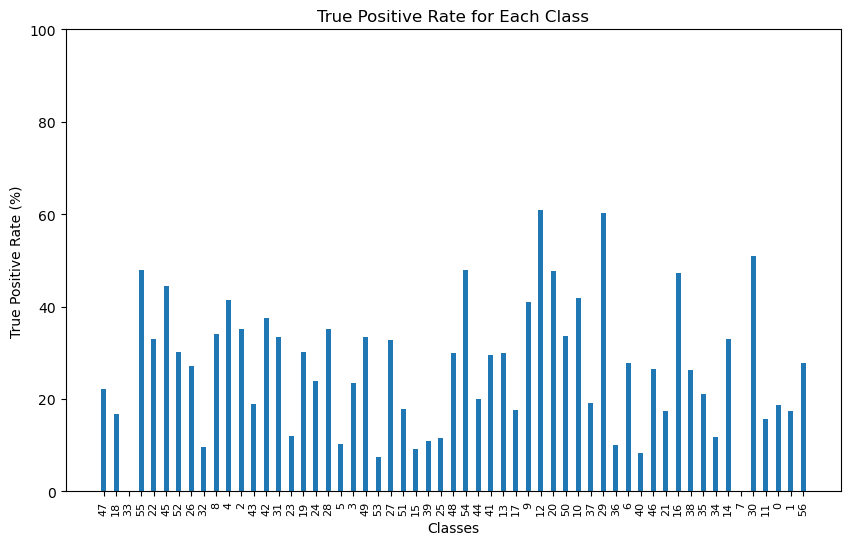

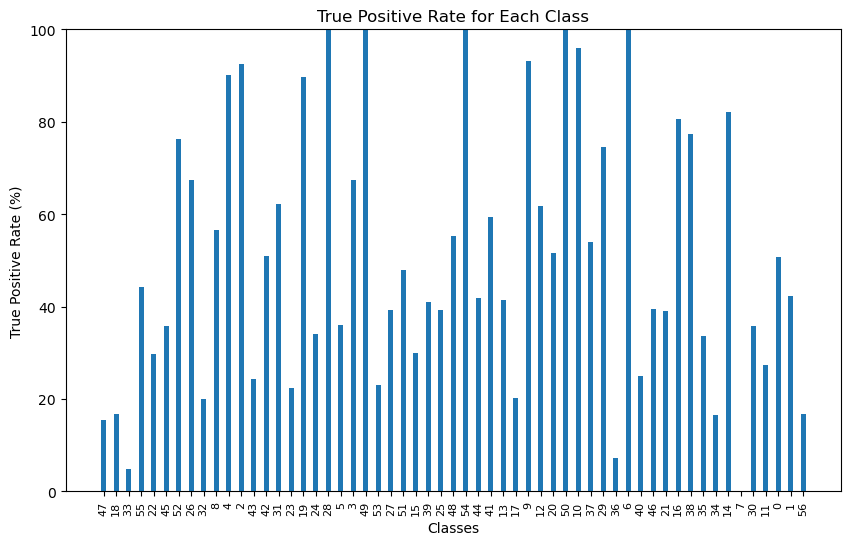

In [23]:
xgb_res =    modelEvaluation(xg_pred, y_test, 'XGB', classes_str)
collect_results_of_all_model["XGB"] = xgb_res

## Random Forest

In [24]:
from sklearn.ensemble import RandomForestClassifier

RF = RandomForestClassifier()
RF.fit(X_train,y_train)

preds_RF = RF.predict(X_test)

========== RF_CLassifier ==========

Accuracy on validation set: 0.3044

Classification report : 
               precision    recall  f1-score   support

          47       0.68      0.16      0.25       135
          18       1.00      0.07      0.12        30
          33       1.00      0.02      0.03        61
          55       0.42      0.50      0.46       327
          22       0.48      0.24      0.32       155
          45       0.41      0.41      0.41       193
          52       0.24      0.30      0.26       355
          26       0.23      0.24      0.23       276
          32       0.71      0.05      0.09       105
           8       0.29      0.23      0.26       205
           4       0.27      0.49      0.35       517
           2       0.21      0.30      0.25       370
          43       0.50      0.13      0.20       111
          42       0.36      0.38      0.37       141
          31       0.29      0.22      0.25       297
          23       0.44      0.07   

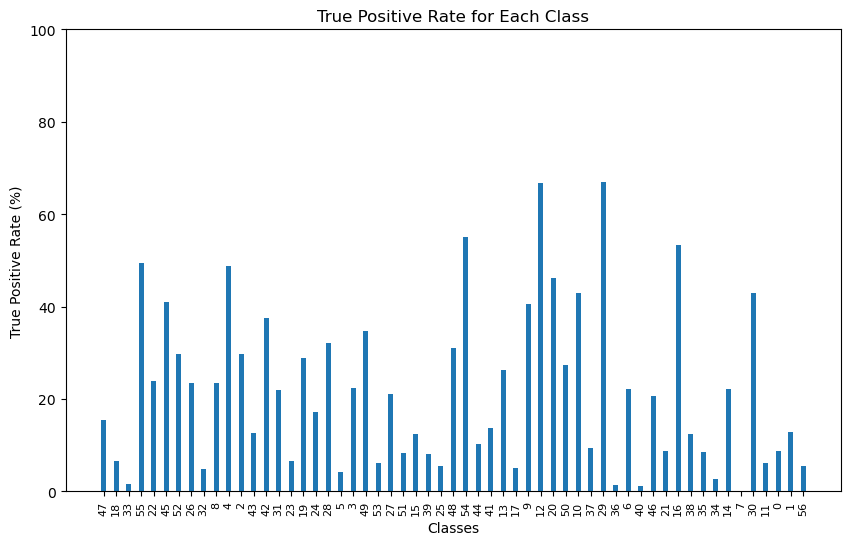

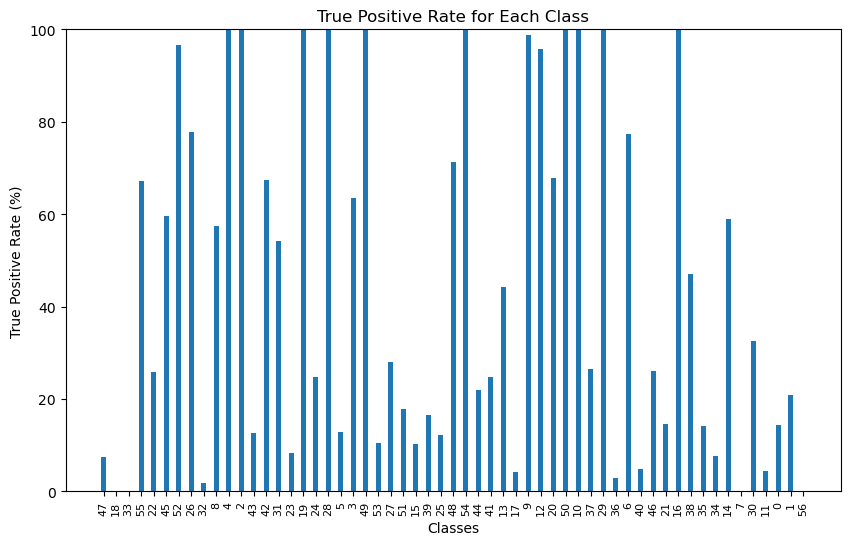

In [25]:
RF_res = modelEvaluation(preds_RF, y_test, 'RF_CLassifier', classes_str)
collect_results_of_all_model["RF_CLassifier"] = RF_res

## Logistic Regression

In [26]:
from sklearn.linear_model import LogisticRegression

LR = LogisticRegression(random_state=0)
LR.fit(X_train,y_train)

preds_LR = LR.predict(X_test)

========== LR_CLassifier ==========

Accuracy on validation set: 0.3527

Classification report : 
               precision    recall  f1-score   support

          47       0.43      0.24      0.31       135
          18       0.55      0.20      0.29        30
          33       0.18      0.03      0.06        61
          55       0.49      0.54      0.51       327
          22       0.52      0.43      0.47       155
          45       0.51      0.55      0.53       193
          52       0.30      0.33      0.32       355
          26       0.35      0.34      0.35       276
          32       0.22      0.08      0.11       105
           8       0.35      0.38      0.36       205
           4       0.34      0.44      0.38       517
           2       0.30      0.35      0.32       370
          43       0.49      0.28      0.36       111
          42       0.38      0.38      0.38       141
          31       0.31      0.32      0.32       297
          23       0.24      0.10   

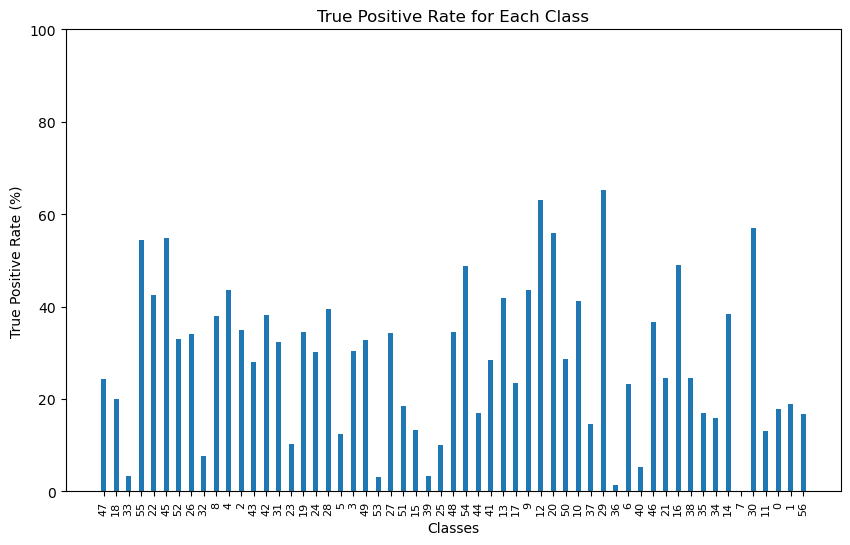

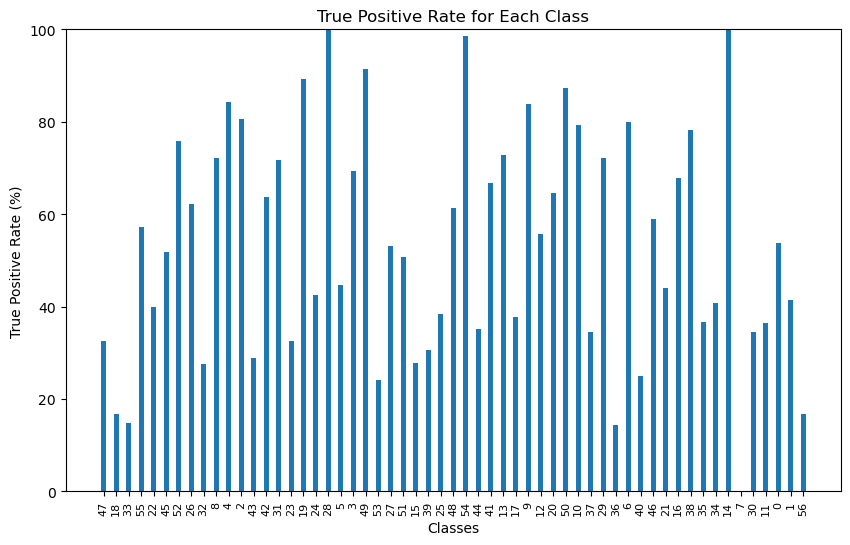

In [27]:
LR_res = modelEvaluation(preds_LR, y_test, 'LR_CLassifier', classes_str)
collect_results_of_all_model["LR_CLassifier"] = LR_res

## KNN Model

In [28]:
from sklearn.neighbors import KNeighborsClassifier

neighbors_clf = KNeighborsClassifier(n_neighbors=5,)
neighbors_clf.fit(X_train,y_train)

KNN_preds = neighbors_clf.predict(X_test)

========== KNN_test ==========

Accuracy on validation set: 0.2793

Classification report : 
               precision    recall  f1-score   support

          47       0.24      0.37      0.29       135
          18       0.17      0.33      0.22        30
          33       0.07      0.16      0.10        61
          55       0.34      0.53      0.41       327
          22       0.28      0.39      0.33       155
          45       0.36      0.47      0.41       193
          52       0.19      0.35      0.24       355
          26       0.14      0.28      0.18       276
          32       0.09      0.10      0.10       105
           8       0.15      0.32      0.21       205
           4       0.25      0.43      0.31       517
           2       0.16      0.26      0.20       370
          43       0.20      0.23      0.22       111
          42       0.23      0.43      0.30       141
          31       0.19      0.28      0.23       297
          23       0.12      0.13      0.

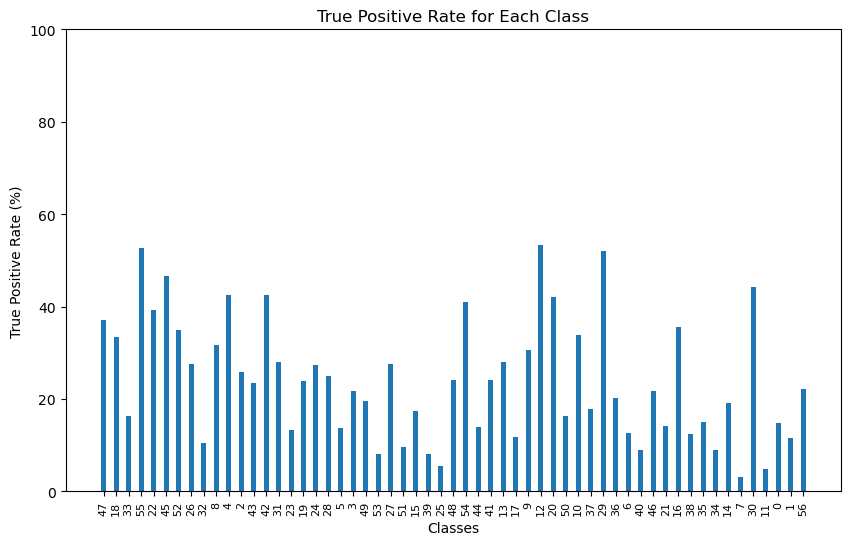

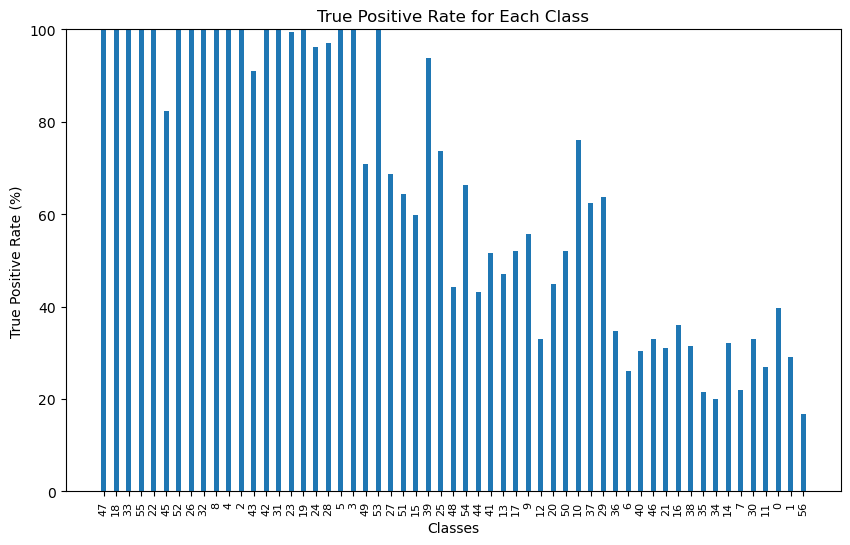

In [29]:
KNN_res = modelEvaluation(KNN_preds, y_test,'KNN_test',classes_str  )
collect_results_of_all_model["KNN"] = KNN_res

# Results Comparison

In [30]:
from tabulate import tabulate 
metrics_data_frame = pd.DataFrame(collect_results_of_all_model)#create dataframe
metrics_data_frame = metrics_data_frame.set_index('Metrics')#set index
# displaying the DataFrame
print(tabulate(metrics_data_frame, headers = 'keys', tablefmt = 'psql'))#convert results in to table

+-----------+----------+-----------------+-----------------+----------+
| Metrics   |      XGB |   RF_CLassifier |   LR_CLassifier |      KNN |
|-----------+----------+-----------------+-----------------+----------|
| accuracy  | 0.333582 |        0.304399 |        0.352747 | 0.279323 |
| precision | 0.345241 |        0.381101 |        0.326152 | 0.265953 |
| recall    | 0.268364 |        0.219163 |        0.285795 | 0.240829 |
| f1-score  | 0.285052 |        0.225761 |        0.292318 | 0.237991 |
+-----------+----------+-----------------+-----------------+----------+


Text(0.5, 0, 'Evaluation Measure')

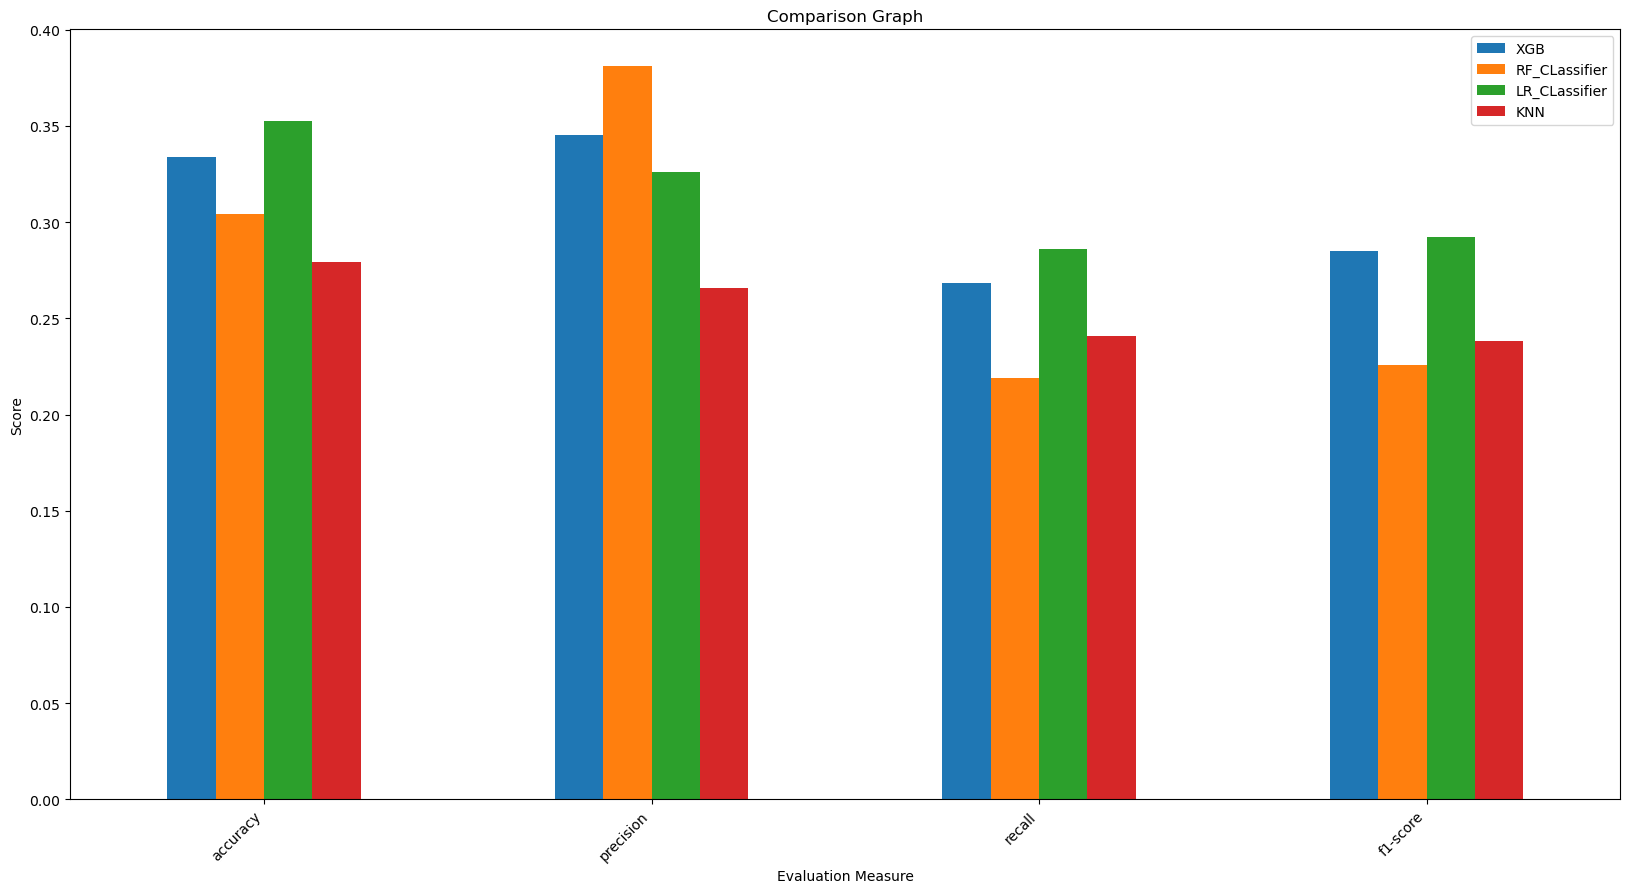

In [31]:
metrics_data_frame.plot(kind='bar', figsize=(20,10)) #sho comparison base of mertics
plt.xticks(rotation=45, horizontalalignment='right')
plt.title('Comparison Graph')
plt.ylabel('Score')
plt.xlabel("Evaluation Measure")